# Computational Geometry in Python
reference: https://github.com/tylerjereddy/pycon-2016


In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import itertools
import circumcircle
import triangle
import numpy as np
import scipy
from scipy.spatial import Delaunay, delaunay_plot_2d, ConvexHull
import scipy.optimize
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import shapefile #Python pyshp library
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.collections import PolyCollection
from matplotlib.collections import PatchCollection
from matplotlib import colors
import time

## 2. Polygons
### 2.1 Definition:  
"A polygon is the closed region of the plane bounded by a finite collection of line segments forming a closed curve that does `not intersect itself`."

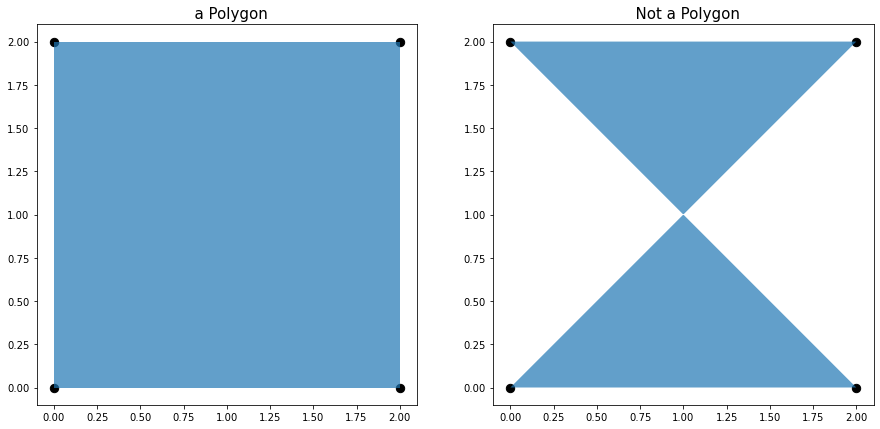

In [3]:
fig_2_1, ax = plt.subplots(1,2, figsize=(15,7))

polygon_vertices = np.array([[0,2],  # top left vertex
                            [2,2],   # top right vertex
                            [2,0],   # bot right vertex
                            [0,0]])  # bot left vertex

ax[0].scatter(polygon_vertices[..., 0], polygon_vertices[..., 1], color='black', s=70)
polygon = Polygon(polygon_vertices, alpha=0.7)
ax[0].add_patch(polygon)
ax[0].set_title('  a Polygon', fontsize=15);

self_intersection_vertices = np.array([[0,2],  # top left vertex
                                       [2,2],  # top right vertex
                                       [0,0],  # bot left vertex
                                       [2,0]]) # bot right vertex

ax[1].scatter(self_intersection_vertices[..., 0], self_intersection_vertices[..., 1], color='black', s=70)
polygon = Polygon(self_intersection_vertices, alpha=0.7)
ax[1].add_patch(polygon)
ax[1].set_title('  Not a Polygon', fontsize=15)

plt.show()

### 2.1 Every Polygon Has a `Triangulation`:

1. **Diagonal**: a line segment `connecting two vertices of P` and lying in the interior of P, not touching $\partial$P `except at its endpoints`
2. **Triangulation**: a decomposition of P into triangles by a maximal set of `noncrossing diagonals`

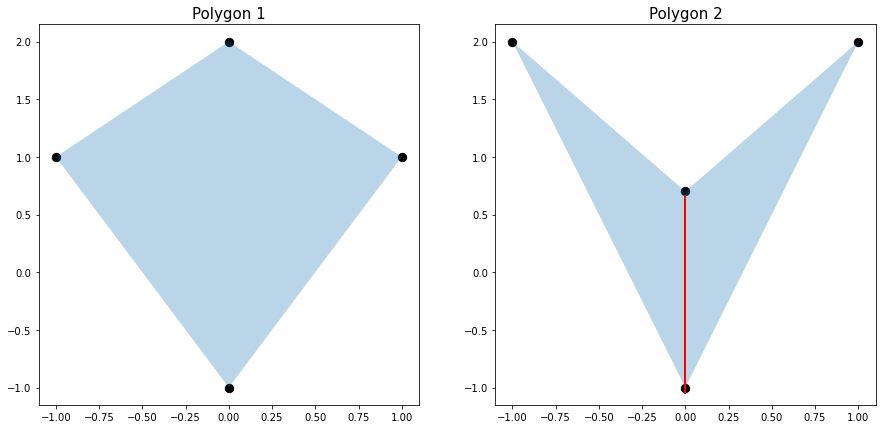

In [4]:
fig_2_2, ax = plt.subplots(1,2, figsize=(15, 7))

polygon_1 = np.array([[0,2],
                      [-1,1],
                      [0,-1],
                      [1,1]])

ax[0].scatter(polygon_1[..., 0], polygon_1[...,1], s=70, color='black')
polygon_1 = Polygon(polygon_1, alpha=0.3)
ax[0].add_patch(polygon_1)
ax[0].set_title('Polygon 1', fontsize=15)

polygon_2 = np.array([[0,0.7],
                      [-1,2],
                      [0,-1],
                      [1,2]])

ax[1].scatter(polygon_2[..., 0], polygon_2[...,1], s=70, color='black')
polygon_2 = Polygon(polygon_2, alpha=0.3)
ax[1].add_patch(polygon_2)
ax[1].set_title('Polygon 2', fontsize=15)
ax[1].axvline(x=0,ymin=0.03,ymax=0.55,color='red',lw=2)

plt.show()

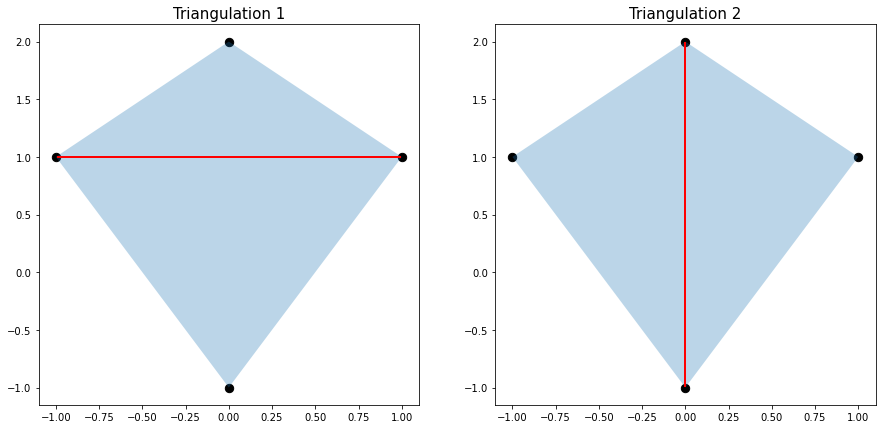

In [5]:
fig_2_2, ax = plt.subplots(1,2, figsize=(15, 7))

polygon_1_t_1 = np.array([[0,2],
                      [-1,1],
                      [0,-1],
                      [1,1]])

polygon_1_t_2 = np.array([[0,2],
                      [-1,1],
                      [0,-1],
                      [1,1]])

ax[0].scatter(polygon_1_t_1[..., 0], polygon_1_t_1[...,1], s=70, color='black')
polygon_1_t_1 = Polygon(polygon_1_t_1, alpha=0.3)
ax[0].add_patch(polygon_1_t_1)
ax[0].set_title('Triangulation 1', fontsize=15)
ax[0].axhline(y=1, xmin=0.05 ,xmax=0.95,color='red',lw=2)

ax[1].scatter(polygon_1_t_2[..., 0], polygon_1_t_2[...,1], s=70, color='black')
polygon_1_t_2 = Polygon(polygon_1_t_2, alpha=0.3)
ax[1].add_patch(polygon_1_t_2)
ax[1].set_title('Triangulation 2', fontsize=15)
ax[1].axvline(x=0,ymin=0.05,ymax=0.95,color='red',lw=2)

plt.show()

### 2.3 Every triangulation of a polygon with ` n vertices` has `n-2 triangles`

In [6]:
oregon = gpd.read_file('tutorial/shapefiles/cb_2015_us_state_20m.shp')
oregon.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,48,01779801,0400000US48,48,TX,Texas,00,676634395761,19027462392,"POLYGON ((-106.62345 31.91403, -106.63011 31.9..."
1,06,01779778,0400000US06,06,CA,California,00,403488955894,20477992907,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
2,21,01779786,0400000US21,21,KY,Kentucky,00,102266253024,2389483091,"POLYGON ((-89.54443 36.57451, -89.47935 36.566..."
3,13,01705317,0400000US13,13,GA,Georgia,00,149169759045,4740824950,"POLYGON ((-85.60516 34.98468, -85.47434 34.983..."
4,55,01779806,0400000US55,55,WI,Wisconsin,00,140269484183,29365442607,"MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ..."


In [7]:
def vertices_count(state, city):
    df = state[state['NAME']==city]
    idx = state[state['NAME']==city].index[0]
    vertices_list = []
    
    try:
        for v_x, v_y in df['geometry'][idx].exterior.coords:
            vertices_list.extend([v_x, v_y])
    except:
        return "'MultiPolygon' object has no attribute 'exterior'"
    
    return len(vertices_list), vertices_list

georgia = vertices_count(oregon, 'Georgia')

# Attempted validation through Oregon-State data but failed.
# need to find another way.

### 2.3 `n-2 Triangles` Validation

reference :  https://www.w3schools.com/python/scipy/scipy_spatial_data.php

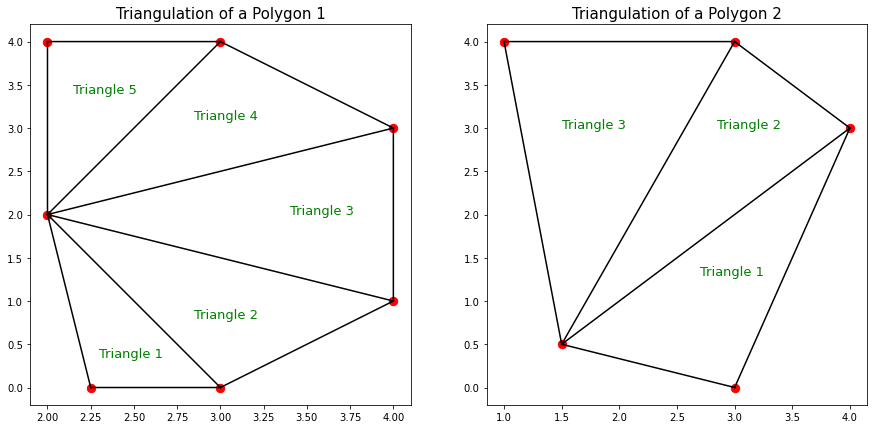

In [84]:
fig_2_3, ax = plt.subplots(1,2, figsize=(15,7))

points_1 = np.array([[2, 4],
                    [3, 4],
                    [3, 0],
                    [2, 2],
                    [4, 3],
                    [4, 1],
                    [2.25, 0]])

simplices = Delaunay(points_1).simplices

ax[0].triplot(points_1[:, 0], points_1[:, 1], simplices, color='black')
ax[0].scatter(points_1[:, 0], points_1[:, 1], color='red', s=70)
ax[0].set_title('Triangulation of a Polygon 1', fontsize=15)
ax[0].text(2.3,0.35,'Triangle 1', fontsize = 13, color='green')
ax[0].text(2.85,0.8,'Triangle 2', fontsize = 13, color='green')
ax[0].text(3.4,2,'Triangle 3', fontsize = 13, color='green')
ax[0].text(2.85,3.1,'Triangle 4', fontsize = 13, color='green')
ax[0].text(2.15,3.4,'Triangle 5', fontsize = 13, color='green')

points_2 = np.array([[1, 4],
                    [3, 4],
                    [3, 0],
                    [1.5, 0.5],
                    [4, 3]])

simplices = Delaunay(points_2).simplices

ax[1].triplot(points_2[:, 0], points_2[:, 1], simplices, color='black')
ax[1].scatter(points_2[:, 0], points_2[:, 1], color='red', s=70)
ax[1].set_title('Triangulation of a Polygon 2', fontsize=15)
ax[1].text(2.7,1.3,'Triangle 1', fontsize = 13, color='green')
ax[1].text(2.85,3,'Triangle 2', fontsize = 13, color='green')
ax[1].text(1.5,3,'Triangle 3', fontsize = 13, color='green')

plt.show()